In [2]:
import os
import math
from collections import namedtuple
from multiprocessing import Pool
import json

import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import h5py


In [3]:
DIMENSION = 256
QUERY_COUNT = 1000
ITEM_COUNT = 10 ** 6
GT_TOP_LEN = 10000
RECALL_TOP_LEN = 5

MIN_EF_SEARCH = 1
MAX_EF_SEARCH = 10000
HIDDEN_DIMENSIONS = [0]
RECALL_OF_INTEREST = 0.95
N_SEARCH_THREADS = 8
REGENERATE_DATA = True
RECALC_RESULTS = False
DATASET = "deep256"
RESULT_PATH = "data/{}/experiment_results.json".format(DATASET)


In [4]:
build_graph_cmd_template = (
    "./RPG --mode base "
    "--baseSize 1000000 "
    "--trainQueries {featuresSize} "
    "--base data/{dataset}/data/{features}.bin "
    "--outputGraph {graphPath} "
    "--relevanceVector {relevanceVector} "
    "--efConstruction 1000 --M 8 "
    "--metric {metric}"
)



In [5]:
search_cmd_template = (
    "./RPG --mode query --baseSize 1000000 --querySize 1000"
    " --query data/{dataset}/data/model_scores/{scores} --inputGraph {inputGraph}"
    " --efSearch {efSearch} --topK {topK} --output data/{dataset}/{searchResultFile}.txt" +
    " --gtQueries 1000 --gtTop {} ".format(GT_TOP_LEN) +
    "--groundtruth data/{dataset}/data/model_scores/{gtFile}"
)

In [6]:
def read_fvecs(file_name):
    a = np.fromfile(file_name, dtype="int32")
    dim = a[0]
    return a.view("float32").reshape((-1, dim + 1))[:,1:]

In [7]:
def sort_by(results, key):
    assert key in ["evals", "efSearch"]
    permutation = np.argsort(results[key])
    for key in results:
        vals = results[key]
        results[key] = [vals[i] for i in permutation]
    return results

assert sort_by({
    "efSearch": [2, 0, 3, 1],
    "vals": [1, 2, 3, 4]}, "efSearch") == {
    "efSearch": [0, 1, 2, 3],
    "vals": [2, 4, 1, 3]
}

In [8]:
def get_evals_for_recall(results, recall=RECALL_OF_INTEREST):
    results = sort_by(results, "evals")
    evals = results["evals"]
    recalls = results["recall"]
    ef_serch = results["efSearch"] if "efSearch" in results else evals
    assert len(evals) == len(recalls)
    
    lower_bound = 0
    lower_bound_ef = MIN_EF_SEARCH
    upper_bound = math.inf
    upper_bound_ef = MAX_EF_SEARCH
    
    if not evals:
        return lower_bound, upper_bound
    
    
    if recalls[0] <= recall:
        lower_bound = evals[0]
        lower_bound_ef = ef_serch[0]
        i = 1
        while i < len(evals) and recalls[i] <= recall:
            lower_bound = evals[i]
            lower_bound_ef = ef_serch[i]
            i += 1
    
    if recalls[-1] >= recall:
        upper_bound = evals[-1]
        upper_bound_ef = ef_serch[-1]
        i = len(evals) - 2
        while i >= 0 and recalls[i] >= recall:
            upper_bound = evals[i]
            upper_bound_ef = ef_serch[i]
            i -= 1
    
    return (lower_bound, upper_bound), (lower_bound_ef, upper_bound_ef)

assert get_evals_for_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.94, 0.95, 0.96, 0.97]
}) == ((2, 2), (2, 2))
assert get_evals_for_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.94, 0.955, 0.96, 0.97]
}) == ((1, 2), (1, 2))
assert get_evals_for_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.96, 0.94, 0.96, 0.97]
}) == ((0, 3), (0, 3))


In [9]:
def merge_results(lhs_res, rhs_res):
    assert not rhs_res or sorted(lhs_res.keys()) == sorted(rhs_res.keys())
    merged_res = {}
    for key in lhs_res:
        merged_res[key] = list(lhs_res[key]) + list(rhs_res.get(key, []))
    return merged_res


In [10]:
def logspace(start, stop, count, include_ends=True):
    cnt_ = count if include_ends else count + 2
    seq = np.unique(np.exp(
        np.linspace(np.log(start), np.log(stop), cnt_)
    ).astype("int"))
    if include_ends:
        return seq
    return seq[1:-1]

In [11]:
def bench_cmd(cmd):
    res = {}
    cmd_out = []
    with os.popen(cmd) as out:
        for line in out:
            cmd_out.append(line)
            for stat_name, prefix, suff_len in [
                ("relevance", "Average relevance: ", 1),
                ("recall", "Recall@5: ", 1),
                ("time", "Average query time: ", 3),
                ("evals", "Average number of model computations: ", 1)
            ]:
                if line.startswith(prefix):
                    res[stat_name] = float(line[len(prefix):-suff_len])
    return res, "".join(cmd_out)

def run_search(graph_path, scores_file, ef_ticks, topK=5,
               result_file=None, n_threads=8, verbose=True,
               gt_file="groundtruth_test.bin"
              ):
    if result_file is None:
        result_file = "result.txt"
    else:
        assert len(ef_ticks) == 1
    
    commands = []
    for ef in ef_ticks:
        commands.append(search_cmd_template.format(
            dataset=DATASET,
            scores=scores_file,
            inputGraph=graph_path,
            efSearch=ef,
            topK=topK,
            searchResultFile=result_file,
            gtFile=gt_file
        ))
    pool = Pool(processes=n_threads)
    results = pool.map(bench_cmd, commands)
    output = {"relevance": [], "recall": [], "time": [], "evals": []}
    for i, (res, cmd_out) in enumerate(results):
        if all(key in res for key in output):
            for key in output:
                output[key].append(res[key])
        else:
            if verbose:
                print("missed result for {} efSearch {}.".format(graph_path, ef_ticks[i]))
                print(cmd_out)
    output["efSearch"] = [int(t) for t in ef_ticks]
    return output

In [12]:
def search_recall(graph_path, scores_file,
                  iterations=2, runs_per_iteration=None,
                  recall_of_interest=RECALL_OF_INTEREST, n_threads=8,
                  gt_file="groundtruth_test.bin"
                 ):
    if runs_per_iteration is None:
        runs_per_iteration = n_threads
    
    lower_ef_search_bound = MIN_EF_SEARCH
    upper_ef_search_bound = MAX_EF_SEARCH
    cur_results = {}
    for i in range(iterations):
        ef_ticks = logspace(lower_ef_search_bound, upper_ef_search_bound,
                            runs_per_iteration, include_ends=(i==0))
        result_update = run_search(graph_path, scores_file,
                                   ef_ticks=ef_ticks, n_threads=n_threads, gt_file=gt_file)
        cur_results = merge_results(result_update, cur_results)
        _, (lower_ef_search_bound, upper_ef_search_bound) = get_evals_for_recall(
            cur_results, recall=recall_of_interest)
    return sort_by(cur_results, "efSearch")

In [13]:
def read_txt(file_name, expected_shape=None):
    data = []
    with open(file_name) as fin:
        for line in fin:
            data.append([int(w) for w in line.split()])
    row_len = len(data[0])
    assert all(len(l) == row_len for l in data)
    if expected_shape is not None:
        assert expected_shape == (len(data), row_len)
    return data


def calc_eval_recall_curve(approximate_top, gt_top):
    assert gt_top.shape == (QUERY_COUNT, RECALL_TOP_LEN)
    
    gt_tops = [set(query_top) for query_top in gt_top]
    recalls = []
    found_count = 0
    top_len = len(approximate_top[0])
    for i in range(top_len):
        for query_id in range(QUERY_COUNT):
            if approximate_top[query_id][i] in gt_tops[query_id]:
                found_count += 1
        recalls.append(found_count / (QUERY_COUNT * RECALL_TOP_LEN))
    evals = list(range(1, top_len + 1))
    return {"evals": evals, "recall": recalls}
    

In [17]:
# def calc_pairwise_relevance(i, q):
#     return -(pairwise_distances(i, q, n_jobs=-1) ** 2).astype("float32")

def calc_pairwise_relevance(i, q):
    return pairwise_distances(i, q, metric="cosine").astype("float32")

In [15]:
def normalize(a):
    vec_lengths = np.sqrt(np.power(a, 2).sum(axis=1, keepdims=True))
    return a / vec_lengths


In [16]:
if REGENERATE_DATA:
    print("Prepare deep256 data")
    items = normalize(read_fvecs("data/deep256/deep1M_base.fvecs"))
    learn = normalize(read_fvecs("data/deep256/deep1M_learn.fvecs"))
    test_queries = normalize(read_fvecs("data/deep256/deep1M_queries.fvecs"))

    assert items.shape == (ITEM_COUNT, DIMENSION)
    assert test_queries.shape == (QUERY_COUNT, DIMENSION)
    
    np.random.seed(0)
    np.random.shuffle(learn)
    train_queries = learn[:QUERY_COUNT]
    train_queries.tofile("data/{}/data/train_queries.bin".format(DATASET))
    del learn

    test_queries.tofile("data/{}/data/test_queries.bin".format(DATASET))
    items.tofile("data/{}/data/items.bin".format(DATASET))
else:
    train_queries = np.fromfile(
        "data/{}/data/train_queries.bin".format(DATASET),
        dtype="float32"
    ).reshape((QUERY_COUNT, DIMENSION))
    test_queries = np.fromfile(
        "data/{}/data/test_queries.bin".format(DATASET),
        dtype="float32"
    ).reshape((QUERY_COUNT, DIMENSION))
    items = np.fromfile(
        "data/{}/data/items.bin".format(DATASET),
        dtype="float32"
    ).reshape((ITEM_COUNT, DIMENSION))

Prepare deep256 data


In [18]:
if REGENERATE_DATA:
    print("compute ground truth test scores")
    gt_train_scores = calc_pairwise_relevance(items, train_queries)
    gt_train_scores.tofile("data/{}/data/model_scores/gt_train_scores.bin".format(DATASET))
    del gt_train_scores

    gt_test_scores = calc_pairwise_relevance(items, test_queries)
    gt_test_scores.tofile("data/{}/data/model_scores/gt_test_scores.bin".format(DATASET))
    del gt_test_scores
    
    print("Calc ground truth nearest neighbors")
    for data_part in ["train", "test"]:
        scores_path = "data/{}/data/model_scores/gt_{}_scores.bin".format(DATASET, data_part)
        scores = np.fromfile(scores_path, dtype="float32").reshape(
            (ITEM_COUNT, QUERY_COUNT))
        gt = (-scores).argsort(axis=0)[:GT_TOP_LEN,:].T.astype("int32")
        gt.tofile("data/{}/data/model_scores/groundtruth_{}.bin".format(DATASET, data_part))
        del scores
        del gt

compute ground truth test scores
Calc ground truth nearest neighbors


In [18]:
print("compute test scores for models with hidden dimensions") 
for hidden_dim_count in HIDDEN_DIMENSIONS:
    hidden_scores_path = "data/{}/data/model_scores/hidden_{}_test_scores.bin".format(
        DATASET, hidden_dim_count
    )
    if not os.path.isfile(hidden_scores_path) or REGENERATE_DATA:
        hidden_model_test_scores = calc_pairwise_relevance(
            items[:,:DIMENSION - hidden_dim_count],
            test_queries[:,:DIMENSION - hidden_dim_count]
        )
        hidden_model_test_scores.tofile(hidden_scores_path)
        del hidden_model_test_scores

compute ground truth test scores
Calc ground truth nearest neighbors
compute test scores for models with hidden dimensions


In [19]:
if REGENERATE_DATA or RECALC_RESULTS:
    results = {}
else:
    with open(RESULT_PATH) as fin:
        results = json.load(fin)


In [20]:

for hidden_dim_count in HIDDEN_DIMENSIONS:
    graph_path = "data/{}/hidden_{}_of_{}_graph.out".format(
        DATASET, hidden_dim_count, DIMENSION
    )
    if not os.path.isfile(graph_path) or REGENERATE_DATA:
        build_cmd = build_graph_cmd_template.format(
            dataset=DATASET,
            featuresSize=DIMENSION,
            graphPath=graph_path,
            relevanceVector=DIMENSION - hidden_dim_count,
            features="items",
            metric="l2"
        )
        print(build_cmd)
        os.system(build_cmd)
    
    label = "hidden_{}_search_gt".format(hidden_dim_count)
    if label not in results:
        results[label] = search_recall(
            graph_path, "gt_test_scores.bin",
            iterations=3, n_threads=N_SEARCH_THREADS,
            runs_per_iteration=16
        )
    
    label = "hidden_{}_search_rerank".format(hidden_dim_count)
    if label not in results:
        search_result_file = "search_result_hidden_{}".format(hidden_dim_count)
        run_search(
            graph_path,
            "hidden_{}_test_scores.bin".format(hidden_dim_count),
            topK=GT_TOP_LEN,
            ef_ticks=[GT_TOP_LEN],
            result_file=search_result_file,
            n_threads=1,
            verbose=False
        )
        approximate_top = read_txt(
            "data/{}/{}.txt".format(DATASET, search_result_file),
            (QUERY_COUNT, GT_TOP_LEN)
        )
        gt = np.fromfile(
            "data/{}/data/model_scores/groundtruth_test.bin".format(DATASET),
            dtype="int32"
        ).reshape((QUERY_COUNT, GT_TOP_LEN))
        gt = gt[:,:RECALL_TOP_LEN]
        result = calc_eval_recall_curve(approximate_top, gt)
        results[label] = result
    

./RPG --mode base --baseSize 1000000 --trainQueries 256 --base data/deep256/data/items.bin --outputGraph data/deep256/hidden_0_of_256_graph.out --relevanceVector 256 --efConstruction 1000 --M 8 --metric l2


In [21]:
# build graph on relevance vectors
relevance_graph_path = "data/{}/rel_{}_graph.out".format(DATASET, QUERY_COUNT)
if not os.path.isfile(relevance_graph_path) or REGENERATE_DATA:
    build_cmd = build_graph_cmd_template.format(
        dataset=DATASET,
        featuresSize=QUERY_COUNT,
        graphPath=relevance_graph_path,
        relevanceVector=QUERY_COUNT,
        features="model_scores/gt_train_scores",
        metric="l2"
    )
    print(build_cmd)
    os.system(build_cmd)

./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/deep256/data/model_scores/gt_train_scores.bin --outputGraph data/deep256/rel_1000_graph.out --relevanceVector 1000 --efConstruction 1000 --M 8 --metric l2


In [22]:
label = "relevance_search_gt"
results[label] = search_recall(
    relevance_graph_path, "gt_test_scores.bin",
    iterations=3, n_threads=N_SEARCH_THREADS,
    runs_per_iteration=16
)

In [23]:
for hidden_dim_count in HIDDEN_DIMENSIONS:
    if hidden_dim_count == 0:
        continue
    label = "relevance_search_hidden_{}".format(hidden_dim_count)
    if label not in results:
        search_result_file = "search_result_rel_hidden_{}".format(hidden_dim_count)
        run_search(
            relevance_graph_path,
            "hidden_{}_test_scores.bin".format(hidden_dim_count),
            topK=GT_TOP_LEN,
            ef_ticks=[GT_TOP_LEN],
            result_file=search_result_file,
            n_threads=1,
            verbose=False
        )
        approximate_top = read_txt(
            "data/{}/{}.txt".format(DATASET, search_result_file),
            (QUERY_COUNT, GT_TOP_LEN)
        )
        gt = np.fromfile(
            "data/{}/data/model_scores/groundtruth_test.bin".format(DATASET),
            dtype="int32"
        ).reshape((QUERY_COUNT, GT_TOP_LEN))
        gt = gt[:,:RECALL_TOP_LEN]
        result = calc_eval_recall_curve(approximate_top, gt)
        results[label] = result


In [24]:
with open(RESULT_PATH, "w") as fout:
    json.dump(results, fout, indent=4)

In [25]:
def plot_chosen_results(results, keys, xlim=None, ylim=None, x_log_scale=False):
    plt.figure(figsize=(10, 10))
    plt.xlabel("evals")
    plt.ylabel("recall@5")
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if x_log_scale:
        plt.xscale("log")
    
    for key in keys:
        assert key in results
        r = results[key]
        x = r["evals"]
        y = r["recall"]
        plt.plot(x, y, label=key)
        pt_size = 0.1 if len(x) > 100 else 5
        plt.scatter(x, y, s=pt_size)
    plt.legend()
    plt.show()

In [26]:
list(results.keys())

['hidden_0_search_gt', 'hidden_0_search_rerank', 'relevance_search_gt']

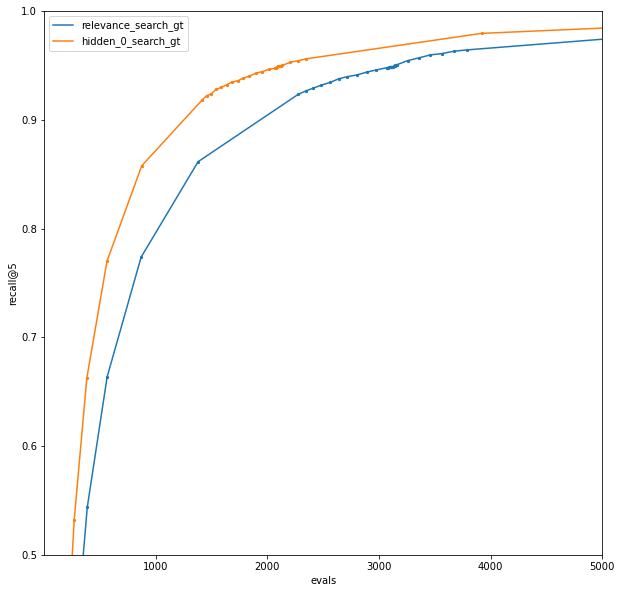

In [32]:
plot_chosen_results(
    results, keys=[
        "relevance_search_gt",        
        "hidden_0_search_gt",
#         "hidden_0_search_rerank",
    ],
    xlim=(1, 5000),
    ylim=(0.5, 1)
#     x_log_scale=True
)

In [ ]:
raise StopIteration

In [ ]:
import pandas as pd
from collections import OrderedDict
from time import time

QUANTILES = [0.9, 0.99, 0.999, 1]

def estimate_disorder(items, scores, gt_top=100, queries_to_sample=100, verbose=False):
    item_count, query_count = scores.shape
    chosen_queries = np.random.choice(query_count, queries_to_sample, replace=False)
    gt = np.argsort(-scores[:,chosen_queries], axis=0)[:gt_top].T
    
    multipliers = []
    start = time()
    for i, q in enumerate(chosen_queries):
        close_items = items[gt[i]]
        ii_dists = pairwise_distances(close_items, items)
        ii_ranks = ii_dists.argsort().argsort()
        for rank_1 in range(1, gt_top):
            for rank_2 in range(0, rank_1):
                ii_rank = ii_ranks[rank_1][gt[i, rank_2]]
                multipliers.append(ii_rank / (2 + rank_1 + rank_2))
        if verbose:
            print("{} queries processed, avg time: {}".format(
                i + 1, (time() - start) / (i + 1)
            ))
    return np.quantile(multipliers, QUANTILES)

def make_table(disoreder_stats : OrderedDict):
    columns = [str(q) for q in QUANTILES]
    labels = []
    data = []
    for key, stats in disoreder_stats.items():
        assert len(stats) == len(QUANTILES)
        data.append(stats)
        labels.append(key)
    result = pd.DataFrame(data=data, columns=columns, index=labels)
    return result.style.format("{:.1f}")


In [ ]:
disorder_stats_path = "data/{}/data/disorder_statistics.json".format(DATASET)

if not os.path.isfile(disorder_stats_path) or REGENERATE_DATA:
    disorder_stats = OrderedDict()
    item_features = np.fromfile(
        "data/{}/data/model_scores/gt_train_scores.bin".format(DATASET),
        dtype="float32"
    ).reshape(ITEM_COUNT, QUERY_COUNT)
    relevance_scores = np.fromfile(
        "data/{}/data/model_scores/gt_test_scores.bin".format(DATASET),
        dtype="float32"
    ).reshape(ITEM_COUNT, QUERY_COUNT)

    disorder_stats["relevance_proximity"] = estimate_disorder(
        item_features, relevance_scores,
        queries_to_sample=100
    )
    del item_features

    for hidden_dim_count in HIDDEN_DIMENSIONS:
        open_dims = DIMENSION - hidden_dim_count
        disorder_stats["hidden_{}".format(hidden_dim_count)] = estimate_disorder(
            items[:,:open_dims], relevance_scores
        )
    del relevance_scores

    for k in disorder_stats:
        disorder_stats[k] = [float(num) for num in disorder_stats[k]]
    with open(disorder_stats_path, "w") as fout:
        json.dump(disorder_stats, fout, indent=4)
else:
    with open(disorder_stats_path) as fin:
        disorder_stats = json.load(fin)

make_table(disorder_stats)